# Red sea balances

Here we will run the partial least squares balances on the red sea dataset, with the goal of performing regression.

In [1]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from gneiss.util import match

from pls_balances.src.balances import balance_regression, round_balance
import qiime2
import numpy as np
import matplotlib

%matplotlib inline
np.random.seed(0)
#font = {'family' : 'norma
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [2]:
data_dir = '../data/redsea'
table_file = '%s/all_samples_KOs_renorm_unstratified.tsv' % data_dir
metadata_file = '%s/krse2011_v5_metadata.csv' % data_dir

table = pd.read_table(table_file, index_col=0)
metadata = pd.read_csv(metadata_file, index_col=0)

sample_ids = list(map(lambda x: x.split('.')[0], table.columns))
table = pd.DataFrame(table.T.values, index=sample_ids, columns=table.index)
table = table.iloc[:, 2:]
table = pd.DataFrame(multiplicative_replacement(table.values),
                     index=table.index, columns=table.columns
)
#table = table + 1
table, metadata = match(table, metadata)

# set the colors
purple_color = '#A569BD' 
white_color = '#B3B6B7' 
red_color = '#F1948A' 

Now we will fit the Gaussian mixture models and attempt to evaluate how good the fit is.

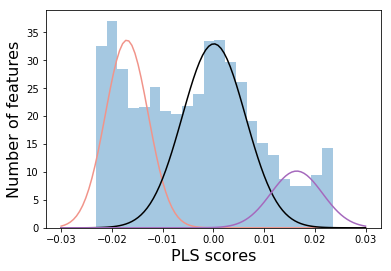

In [3]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize

fig, ax = plt.subplots(figsize=(6, 4))
redsea_pls = PLSRegression(n_components=1)

# centre log transform data to symmetrize the log transform data
ctable = pd.DataFrame(clr(centralize(table)), 
                      index=table.index, columns=table.columns)

redsea_pls.fit(X=ctable.values, Y=metadata.temperature)

redsea_spectrum = pd.DataFrame(redsea_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

redsea_mixture = GaussianMixture(n_components=3, 
                                 means_init=np.array([[-0.02], [0], [0.02]]), 
                                 random_state=0)
redsea_mixture.fit(X=redsea_spectrum.values)

redsea_m = np.ravel(redsea_mixture.means_)
redsea_s = np.ravel(np.sqrt(redsea_mixture.covariances_)) 
redsea_w = np.ravel(redsea_mixture.weights_)

x = np.linspace(-0.03, 0.03, 100)
sns.distplot(redsea_spectrum, norm_hist=True, kde=False, ax=ax)
ax.plot(x, redsea_w[0]*norm.pdf(x, redsea_m[0], redsea_s[0]), red_color)
ax.plot(x, redsea_w[1]*norm.pdf(x, redsea_m[1], redsea_s[1]), '-k')
ax.plot(x, redsea_w[2]*norm.pdf(x, redsea_m[2], redsea_s[2]), purple_color)
ax.set_xlabel('PLS scores', fontsize=16)
ax.set_ylabel('Number of features', fontsize=16)
plt.savefig('../results/figures/figure3_redsea_feature_histogram.pdf')

In [4]:
l, r = round_balance(redsea_spectrum, means_init=np.array([[-0.02], [0], [0.02]]))

denom = redsea_spectrum.loc[redsea_spectrum.PLS1 < l]
num = redsea_spectrum.loc[redsea_spectrum.PLS1 > r]

r, s = num.shape[0], denom.shape[0] 
redsea_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) - 
                  np.log(table.loc[:, denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

In [5]:
res = balance_regression(table, metadata.temperature, num_folds=4, 
                         means_init=np.array([[-0.05], [0], [0.05]]) )
num, denom, redsea_balance, cv = res

In [6]:
cv

,Q2
0,0.718712
1,0.684138
2,0.757057
3,0.740073


In [7]:
cv.Q2.mean()

0.72499502267467597

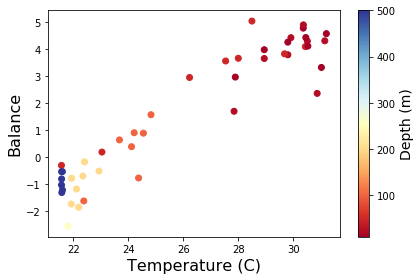

In [9]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

sc = ax.scatter(metadata.temperature, redsea_balance, c=metadata.depth, cmap=cm)
ax.set_xlabel('Temperature (C)', fontsize=16)
ax.set_ylabel('Balance', fontsize=16)
cbar = plt.colorbar(sc)
cbar.set_label(label='Depth (m)', fontsize=14)
plt.tight_layout()
fig.savefig('../results/figures/figure3_redsea_regression.pdf')

In [10]:
from scipy.stats import spearmanr, pearsonr
r, p = spearmanr(redsea_balance, metadata.temperature)
print('CH \t -- R^2: %f \t p-value: \t %E' % (r, p))
r, p = pearsonr(redsea_balance, metadata.temperature)
print('CH \t -- R^2: %f \t p-value: \t %E' % (r, p))

CH 	 -- R^2: 0.874893 	 p-value: 	 3.966139E-15
CH 	 -- R^2: 0.946452 	 p-value: 	 9.820104E-23


In [11]:
num.index

Index(['K00099', 'K00134', 'K00145', 'K00147', 'K00254', 'K00324', 'K00383',
       'K00524', 'K00651', 'K00690',
       ...
       'K11991', 'K13292', 'K13693', 'K14330', 'K14331', 'K15633', 'K15918',
       'K16149', 'K17069', 'K18534'],
      dtype='object', name='# Gene Family', length=137)

In [12]:
denom.index

Index(['K00054', 'K00058', 'K00060', 'K00067', 'K00150', 'K00174', 'K00239',
       'K00240', 'K00248', 'K00260',
       ...
       'K16793', 'K17450', 'K17759', 'K17828', 'K17950', 'K18022', 'K18235',
       'K18285', 'K18459', 'K18855'],
      dtype='object', name='# Gene Family', length=173)

In [13]:
writer = pd.ExcelWriter('../results/redsea_stats.xlsx')

stats = pd.Series([cv['Q2'].mean(), r, p],
                  index=['Q2_CV', 'r', 'p'])
cv['Q2'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

In [67]:
import matplotlib

def rgb2hex(x):
    return '#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255))
f_ids = list(num.index) + list(denom.index) + list(set(potato_spectrum.index) - (set(num.index) | set(denom.index)))

n = len(num.index) 
d = len(denom.index)
o = len(f_ids) - n - d

cmap = matplotlib.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.Normalize(vmin=metadata.temperature.min(), 
                                   vmax=metadata.temperature.max())
temperature_colors = pd.Series([rgb2hex(cmap(norm(i))) for i in metadata.temperature],
                               index=metadata.index, name='Temperature')

feature_colors = pd.Series([rgb2hex(cmap(0))]*n + [rgb2hex(cmap(1000))]*d + ['#D0D3D4']*o,
                           index=f_ids, name='Features')

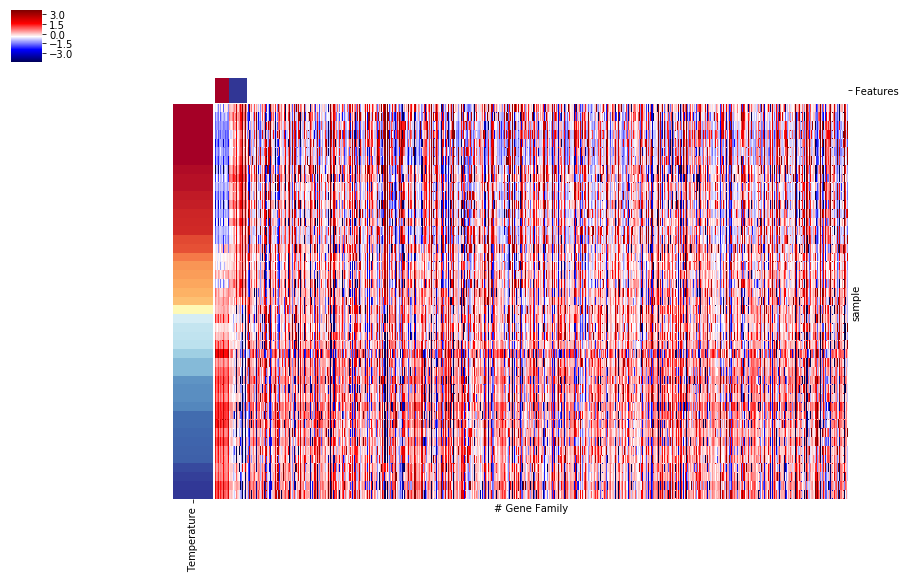

In [79]:
import seaborn as sns
ctable = ctable.reindex(columns=f_ids,
                        index=metadata.temperature.sort_values().index)
#plt.imshow(ctable.values, aspect='auto', interpolation='nearest', cmap='seismic')

G = sns.clustermap(ctable, 
                   row_cluster=False, col_cluster=False, 
                   row_colors=temperature_colors, 
                   col_colors=feature_colors, cmap='seismic', 
                   robust=True, figsize=(15, 9))
_ = G.ax_heatmap.set_xticks([])
_ = G.ax_heatmap.set_yticks([])
G.savefig('../results/figure3_redsea_heatmap_full.pdf')

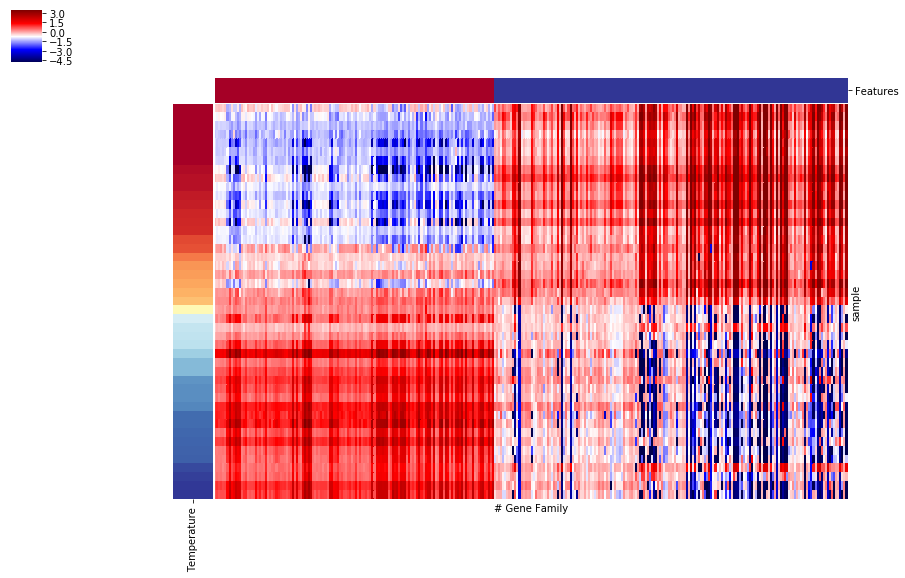

In [78]:
import seaborn as sns
ctable = ctable.reindex(columns=f_ids,
                        index=metadata.temperature.sort_values().index)
#plt.imshow(ctable.values, aspect='auto', interpolation='nearest', cmap='seismic')
feature_colors = pd.Series([rgb2hex(cmap(0))]*n + [rgb2hex(cmap(1000))]*d,
                           index=list(num.index) + list(denom.index), name='Features')

G = sns.clustermap(ctable.loc[:, list(num.index)+list(denom.index)], 
                   row_cluster=False, col_cluster=False, 
                   row_colors=temperature_colors, 
                   col_colors=feature_colors, cmap='seismic', 
                   robust=True, figsize=(15, 9))
_ = G.ax_heatmap.set_xticks([])
_ = G.ax_heatmap.set_yticks([])
G.savefig('../results/figure3_redsea_heatmap_partial.pdf')

# TODO 

We will want to have proportion plots here, with the KEGG annotations.  From this, we'll also want to pull out the interesting differentiating genes.

In [65]:
feature_colors.value_counts()

#D0D3D4    5673
#fddc8c     173
#a50026     137
Name: Features, dtype: int64